# Notebook From https://github.com/KxSystems/kdbai-samples 
# Presented here for convenience

# Pattern Matching on Sensor Data

This example explores the process of conducting pattern matching on time series manufacturing data using a similarity search in KDB.AI. 

Our goal is to identify and retrieve historical time series that exhibit specific patterns. This matching capability is instrumental in a wide array of manufacturing scenarios, including quality control, process optimization, and predictive maintenance. For instance, imagine a scenario where we have time series data representing machinery performance, and we need to pinpoint instances of unusual behaviour, such as spikes, drops, or recurring trends.

We will guide you through a straightforward approach that leverages the raw time series data directly, without the need for complex modelling or domain-specific expertise. This approach is particularly attractive because it doesn't require additional resources for model creation. The sample will demonstrate that this simplistic method can yield satisfactory results. 

### Aim

This tutorial will walk through the process of storing time series data in a vector database, using windowing and normalization to generate simple time series vector embeddings. We will use KDB.AI's vector database to find historical patterns that match an input query pattern. We will cover the following topics:

1. Load Sensor Data
1. Create Sensor Vector Embeddings
1. Store Embeddings in KDB.AI
1. Search For Similar Sequences To A Target Sensor Sequence
1. Delete the KDB.AI Table

---

## 0. Setup

### Install dependencies 

In order to successfully run this sample, the [Setup](https://github.com/KxSystems/kdbai-samples/blob/main/README.md#setup) steps in the repository's `README.md` file must be completed.
This will ensure that you have installed all of the relevant packages and versions needed for this sample.
If you have not completed these setup steps, please navigate to the repositories `README.md` file and follow the steps detailed there.

### Import Packages

In [3]:
# read data
from zipfile import ZipFile
import pandas as pd

In [4]:
# plotting
import matplotlib.pyplot as plt

In [5]:
import os
from os.path import join, dirname
from dotenv import load_dotenv

# dotenv_path = join(dirname, './.env')
load_dotenv('../.env')

# endpoint          ='XXXX.kdb.ai' 
# api_key1          ='YOUR_KDBAI_API_KEY'

KDBAI_ENDPOINT  = os.environ.get("endpoint") 
KDBAI_API_KEY1  = os.environ.get("api_key1")

# print(KDBAI_ENDPOINT)

In [6]:
# vector DB
import os
import kdbai_client as kdbai
# from getpass import getpass
import time

### Ignore Warning

In [12]:
import warnings

warnings.simplefilter("ignore", UserWarning)

### Define Helper Functions

In [8]:
def show_df(df: pd.DataFrame) -> pd.DataFrame:
    print(df.shape)
    return df.head()

## 1. Load Sensor Data

### Dataset Overview

The dataset that will be used for this example is the [Water Pump Sensor Dataset](https://www.kaggle.com/datasets/nphantawee/pump-sensor-data) available on Kaggle. The datatset consist of a `sensor.csv` file which has raw values from 52 sensors from a town water pump.

As the `sensors.csv` file is >100mb, we cannot host this file on GitHub and must instead zip this file up and extract it locally.

### Extract the Data From a ZipFile

In [9]:
# def extract_zip(file_name):
#     with ZipFile(file_name, "r") as zipf:
#         zipf.extractall("data")

In [17]:
# extract_zip("../data/archive.zip")

You should now have a sensor.csv file.

### Read In The Sensor Data From The CSV

In [18]:
raw_sensors_df = pd.read_csv("../data/archive.zip")

In [10]:
show_df(raw_sensors_df)

(220320, 55)


,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


### Pre-process The Data

Let's do some preparation on the dataset to clean it up. We will remove duplicates, drop  irrelevant columns and handle missing data.

In [11]:
# Drop duplicates
sensors_df = raw_sensors_df.drop_duplicates()

In [12]:
# Remove columns that are unnecessary/bad data
sensors_df = sensors_df.drop(["Unnamed: 0", "sensor_15", "sensor_50"], axis=1)

In [13]:
# convert timestamp to datetime format
sensors_df["timestamp"] = pd.to_datetime(sensors_df["timestamp"])

In [14]:
# Removes rows with any NaN values
sensors_df = sensors_df.dropna()

In [16]:
# Reset the index
sensors_df = sensors_df.reset_index(drop=True)

In [17]:
show_df(sensors_df)

(195815, 52)


,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,201.3889,NORMAL


This dataset has 52 sensor columns - for the purposes of this example we will only select the first one `sensor_00` for simplicity.

### Explore The Data For One Sensor

In [18]:
# Extract the readings from the BROKEN state of the pump
broken_sensors_df = sensors_df[sensors_df["machine_status"] == "BROKEN"]

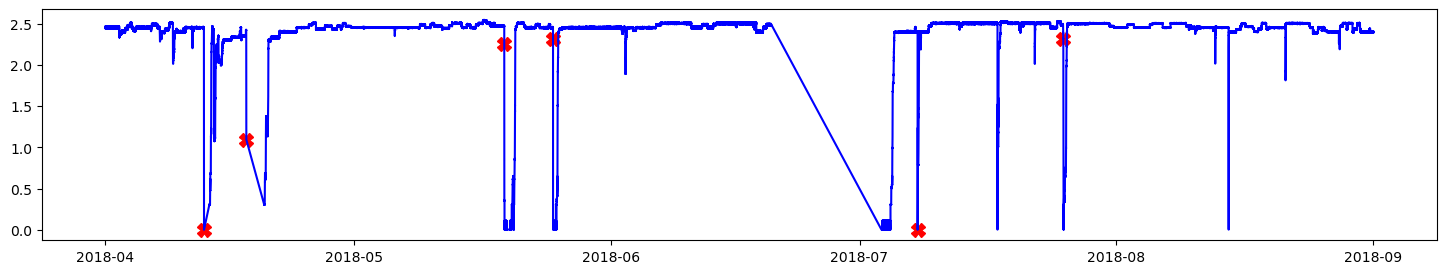

In [19]:
# Plot time series for each sensor with BROKEN state marked with X in red color
plt.figure(figsize=(18, 3))
plt.plot(
    broken_sensors_df["timestamp"],
    broken_sensors_df["sensor_00"],
    linestyle="none",
    marker="X",
    color="red",
    markersize=10,
)
plt.plot(sensors_df["timestamp"], sensors_df["sensor_00"], color="blue")
plt.show()

We can see above that over time the sensor values stay generally around 2.5 with a few noisy dropoff spikes. We have plotted the column `machine_status=BROKEN` in red here which corresponds with a lot of these spikes indicating the reason for the dropoffs.

## 2. Create Sensor Vector Embeddings

Next, let's create embeddings for these values. To do this we use a combination of windowing and normalizing the data. We have chosen a simple approach that leverages the raw time series data directly, without the need for complex modelling or domain-specific expertise.

### Extract One Sensors Values

In [20]:
sensor0_df = sensors_df[["timestamp", "sensor_00"]]

### Group The Sensor0 Values into Time Windows

The code below divides the original time series data into overlapping windows, with each window containing a specified number of rows and a step size determining how they are shifted along the timeline. It also extracts a timestamp from each window as we will want to store this as metadata.

In [21]:
# Set the window size (number of rows in each window)
window_size = 24
step_size = 10

In [22]:
# define windows
windows = [
    sensor0_df.iloc[i : i + window_size]
    for i in range(0, len(sensor0_df) - window_size + 1, step_size)
]

In [23]:
# Iterate through the windows & extract column values
start_times = [w["timestamp"].iloc[0] for w in windows]
end_times = [w["timestamp"].iloc[-1] for w in windows]
sensor0_values = [w["sensor_00"].tolist() for w in windows]

In [24]:
# Create a new DataFrame from the collected data
embedding_df = pd.DataFrame(
    {"start_time": start_times, "end_time": end_times, "vectors": sensor0_values}
)

In [25]:
# Show the resulting DataFrame
show_df(embedding_df)

(19580, 3)


,start_time,end_time,vectors
0,2018-04-01 00:00:00,2018-04-01 00:23:00,"[2.465394, 2.465394, 2.444734, 2.460474, 2.445..."
1,2018-04-01 00:10:00,2018-04-01 00:33:00,"[2.46441, 2.444734, 2.460474, 2.448669, 2.4535..."
2,2018-04-01 00:20:00,2018-04-01 00:43:00,"[2.445718, 2.460474, 2.448669, 2.453588, 2.453..."
3,2018-04-01 00:30:00,2018-04-01 00:53:00,"[2.463426, 2.448669, 2.453588, 2.455556, 2.449..."
4,2018-04-01 00:40:00,2018-04-01 01:03:00,"[2.449653, 2.453588, 2.453588, 2.448669, 2.460..."


### Normalize These Sensor Value Windows

Next, we perform manual normalization of sensor values within each time-based window. This ensures that the sensor values are scaled uniformly between 0 and 1 which is better for further analysis. Additionally, the DataFrame's index is reset to maintain a clean and continuous row numbering.


In [26]:
# Function to normalize the sensor column
def normalize_vector(vectors: list) -> list:
    min_val = min(vectors)
    max_val = max(vectors)
    return (
        [0.0] * len(vectors)
        if max_val == min_val
        else [(v - min_val) / (max_val - min_val) for v in vectors]
    )

In [27]:
embedding_df["vectors"] = embedding_df["vectors"].apply(normalize_vector)

In [28]:
# Show the resulting DataFrame
show_df(embedding_df)

(19580, 3)


,start_time,end_time,vectors
0,2018-04-01 00:00:00,2018-04-01 00:23:00,"[1.0, 1.0, 0.0, 0.7618586640851966, 0.04762826..."
1,2018-04-01 00:10:00,2018-04-01 00:33:00,"[1.0, 0.0, 0.7999593413295418, 0.1999898353323..."
2,2018-04-01 00:20:00,2018-04-01 00:43:00,"[0.05001016466760889, 0.7999593413295418, 0.19..."
3,2018-04-01 00:30:00,2018-04-01 00:53:00,"[0.8571566871581443, 0.14284331284187718, 0.38..."
4,2018-04-01 00:40:00,2018-04-01 01:03:00,"[0.19047388547365338, 0.3809477709472852, 0.38..."


## 3. Store Embeddings in KDB.AI 

With the embeddings created, we need to store them in a vector database to enable efficient searching.

### Define KDB.AI Session

KDB.AI comes in two offerings:

1. [KDB.AI Cloud](https://trykdb.kx.com/kdbai/signup/) - For experimenting with smaller generative AI projects with a vector database in our cloud.
2. [KDB.AI Server](https://trykdb.kx.com/kdbaiserver/signup/) - For evaluating large scale generative AI applications on-premises or on your own cloud provider.

Depending on which you use there will be different setup steps and connection details required.

##### Option 1. KDB.AI Cloud

To use KDB.AI Cloud, you will need two session details - a URL endpoint and an API key.
To get these you can sign up for free [here](https://trykdb.kx.com/kdbai/signup).

You can connect to a KDB.AI Cloud session using `kdbai.Session` and passing the session URL endpoint and API key details from your KDB.AI Cloud portal.

If the environment variables `KDBAI_ENDPOINTS` and `KDBAI_API_KEY` exist on your system containing your KDB.AI Cloud portal details, these variables will automatically be used to connect.
If these do not exist, it will prompt you to enter your KDB.AI Cloud portal session URL endpoint and API key details.

In [29]:
# KDBAI_ENDPOINT = (
#     os.environ["KDBAI_ENDPOINT"]
#     if "KDBAI_ENDPOINT" in os.environ
#     else input("KDB.AI endpoint: ")
# )
# KDBAI_API_KEY = (
#     os.environ["KDBAI_API_KEY"]
#     if "KDBAI_API_KEY" in os.environ
#     else getpass("KDB.AI API key: ")
# )

In [30]:
session = kdbai.Session(api_key=KDBAI_API_KEY1, endpoint=KDBAI_ENDPOINT)

##### Option 2. KDB.AI Server

To use KDB.AI Server, you will need download and run your own container.
To do this, you will first need to sign up for free [here](https://trykdb.kx.com/kdbaiserver/signup/). 

You will receive an email with the required license file and bearer token needed to download your instance.
Follow instructions in the signup email to get your session up and running.

Once the [setup steps](https://code.kx.com/kdbai/gettingStarted/kdb-ai-server-setup.html) are complete you can then connect to your KDB.AI Server session using `kdbai.Session` and passing your local endpoint.

In [31]:
# session = kdbai.Session(endpoint="http://localhost:8082")

### Define Vector DB Table Schema

The next step is to define a schema for our KDB.AI table where we will store our embeddings. Our table will have three colums: startTime, endTime, vectors.

In [32]:
sensor_schema = {
    "columns": [
        {
            "name": "start_time",
            "pytype": "datetime64[ns]",
        },
        {
            "name": "end_time",
            "pytype": "datetime64[ns]",
        },
        {
            "name": "vectors",
            "vectorIndex": {"dims": window_size, "metric": "L2", "type": "hnsw"},
        },
    ]
}

### Create Vector DB Table

Use the KDB.AI `create_table` function to create a table that matches the defined schema in the vector database.

In [33]:
# First ensure the table does not already exist
try:
    session.table("sensors").drop()
    time.sleep(5)
except kdbai.KDBAIException:
    pass

In [34]:
table = session.create_table("sensors", sensor_schema)

### Add Embedded Data to KDB.AI Table

When adding larger amounts of data, you may need insert data into an index in chunks. It is a good idea to first get an idea of how large the dataset to insert is.

In [35]:
embedding_df.memory_usage(deep=True).sum() / (1024**2)  # Convert bytes to MB

5.079166412353516

This is fairly small <10MB due so we are good to add all in one go.

In [36]:
table.insert(embedding_df)

True

### Verify Data Has Been Inserted

Running `table.query()` should show us that data has been added.

In [37]:
show_df(table.query())

(19580, 3)


,start_time,end_time,vectors
0,2018-04-01 00:00:00,2018-04-01 00:23:00,"[1.0, 1.0, 0.0, 0.7618586640851966, 0.04762826..."
1,2018-04-01 00:10:00,2018-04-01 00:33:00,"[1.0, 0.0, 0.7999593413295418, 0.1999898353323..."
2,2018-04-01 00:20:00,2018-04-01 00:43:00,"[0.05001016466760889, 0.7999593413295418, 0.19..."
3,2018-04-01 00:30:00,2018-04-01 00:53:00,"[0.8571566871581443, 0.14284331284187718, 0.38..."
4,2018-04-01 00:40:00,2018-04-01 01:03:00,"[0.19047388547365338, 0.3809477709472852, 0.38..."


## 4. Search For Similar Sequences To A Target Sensor Sequence

Now our data is loaded successfully, we can perform pattern matching on our historical sensor data using KDB.AI `search`. 

### Define an Example Pattern to Query 

The first step is to select a pattern that will be used to query.

We chose this by selecting a start time, filtering to get the vector's values for that record, and then storing this in a variable called `query_vector`. Any pattern could be selected here.

The resulting query pattern is also displayed as a line plot for visual inspection and analysis.

In [38]:
# Select historical pattern
example_window1 = embedding_df[ embedding_df["start_time"] == pd.to_datetime("2018-04-01 13:00:00")]

In [50]:
query_df1

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status
780,2018-04-01 13:00:00,2.448669,47.74305,52.777770,45.833330,633.7963,71.80135,13.38252,16.16753,15.49479,...,36.197914,44.27083,63.94676,56.71296,45.13889,41.666668,217.3032,84.20139,229.1667,NORMAL
781,2018-04-01 13:01:00,2.448669,47.74305,52.777770,45.833330,633.7963,71.80135,13.38252,16.16753,15.49479,...,36.197914,44.27083,63.94676,56.71296,45.13889,41.666668,217.3032,84.20139,229.1667,NORMAL
782,2018-04-01 13:02:00,2.453588,46.87500,52.821180,45.833332,629.6296,72.82842,13.25231,16.16753,15.65393,...,36.197914,44.01041,65.39352,57.00232,45.13889,41.666668,211.8056,88.54166,227.7199,NORMAL
783,2018-04-01 13:03:00,2.456539,46.91840,52.821178,45.833332,631.5972,73.05396,13.43316,16.16753,15.66117,...,36.197914,43.48958,66.26157,57.00232,45.13889,41.666668,207.4653,91.72453,228.8773,NORMAL
784,2018-04-01 13:04:00,2.448669,46.91840,52.821180,45.833332,643.1713,75.51262,13.34635,16.16753,15.56713,...,36.197910,43.22916,67.99769,57.00232,44.84954,41.666670,205.7292,94.32870,229.7454,NORMAL
785,2018-04-01 13:05:00,2.464410,46.91840,52.777770,45.833332,631.1343,75.02529,13.25231,16.13136,15.65393,...,36.458330,43.22916,68.57639,56.42361,44.84954,41.956020,206.0185,99.53703,227.1412,NORMAL
786,2018-04-01 13:06:00,2.444734,47.17882,52.821180,45.833332,630.9028,73.04086,13.44763,16.16753,15.45139,...,36.197910,42.70833,67.70834,56.13426,44.56018,41.956017,205.4398,104.16670,224.8264,NORMAL
787,2018-04-01 13:07:00,2.466377,47.09201,52.777770,45.833332,632.8704,75.50192,13.44763,16.12413,15.69734,...,36.458330,42.70833,66.55093,56.13426,44.56018,41.956017,206.5972,106.19210,223.3796,NORMAL
788,2018-04-01 13:08:00,2.444734,46.91840,52.821180,45.833332,641.5509,71.69236,13.25231,16.12413,15.65393,...,36.458332,42.70833,65.39352,55.55556,44.56018,41.956020,208.0440,105.61340,222.8009,NORMAL
789,2018-04-01 13:09:00,2.459491,46.87500,52.821178,45.833332,633.7963,74.72421,13.30295,16.16753,15.45139,...,36.458330,42.70833,63.65741,54.97685,44.84954,42.245370,210.0694,105.32410,223.3796,NORMAL


In [39]:
# Select historical pattern
query_df1 = sensors_df[
    (sensors_df["timestamp"] >= example_window1.iloc[0]["start_time"]) & (sensors_df["timestamp"] <= example_window1.iloc[0]["end_time"]) ]

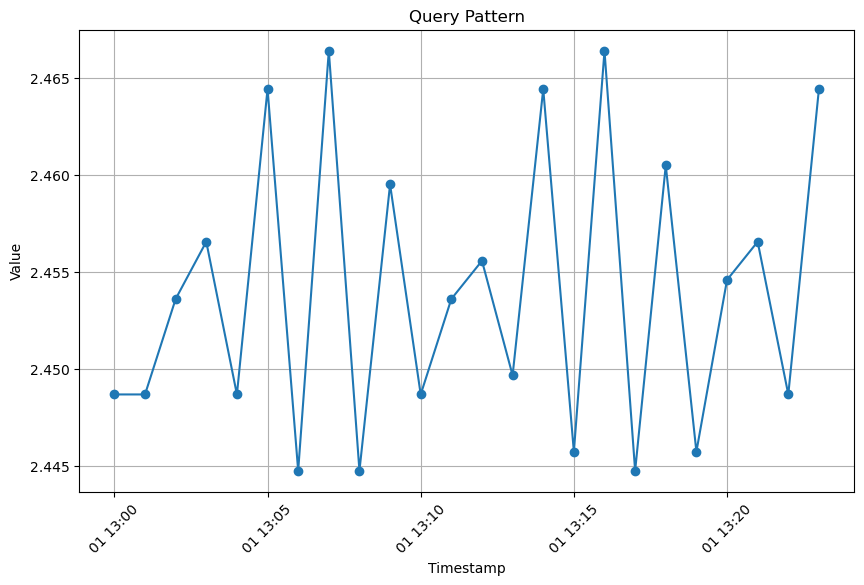

In [49]:
# Visualise the example pattern
plt.figure(figsize=(10, 6))
plt.plot(query_df1["timestamp"], query_df1["sensor_00"], marker="o", linestyle="-")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.title("Query Pattern")
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

### Search KDB.AI Based on this Example Pattern

We can extract the vectors from the example window selected above into a `query_vector` and search the vector database to get the five nearest other windows to this pattern.

In a real life scenario, the example pattern could be some real time data as selected by a machine operator or engineer to pinpoint instances of unusual behavior such as spikes, drops, or recurring trends.

In [41]:
# Extract the sensor values in this window
query_vector1 = example_window1["vectors"].values.tolist()

In [42]:
nn1_result   = table.search(query_vector1, n=5)
nn1_result[0]

,start_time,end_time,vectors,__nn_distance
0,2018-04-01 13:00:00,2018-04-01 13:23:00,"[0.1818139814258758, 0.1818139814258758, 0.409...",0.000000
1,2018-04-12 16:00:00,2018-04-12 16:23:00,"[0.2499788225328221, 0.2499788225328221, 0.416...",0.177821
2,2018-04-02 06:20:00,2018-04-02 06:43:00,"[0.6818370835836001, 0.1818139814258758, 0.500...",0.295486
3,2018-06-01 11:33:00,2018-06-01 11:56:00,"[0.3332956855658574, 0.44443189518861076, 0.44...",0.321309
4,2018-04-06 05:30:00,2018-04-06 05:53:00,"[0.5000000000000113, 0.25000000000000566, 0.50...",0.321494


The results returned from `table.search` show the closest matches along with value of nearest neighbor distances `nn_distance`. This is helpful to keep in for visulization purposes so we can compare how similar it is to the matches found.

The first result is an exact match as the example pattern we chose was from the existing dataset. 

### Visualize These Nearest Neighbour Results

Let's plot these neighbors overlayed with each other on a chart. This is useful for visualizing and analyzing time series data patterns and their relationships.

The code snippet below performs a time-based pattern matching and visualization process, calculating time differences, assiging labels to patterns, and then plotting these patterns with legends to distinguish and display them.

In [47]:
# Iterate through the rows of df1 to filter df and calculate time differences
full_nn1_df = pd.DataFrame()
for i, row in nn1_result[0].iterrows():
    filtered_df                    = sensors_df[ (sensors_df["timestamp"] >= row["start_time"]) & (sensors_df["timestamp"] <= row["end_time"]) ].copy()
    filtered_df["time_difference"] = filtered_df["timestamp"] - row["start_time"]
    filtered_df["pattern"] = i + 1
    full_nn1_df = pd.concat([full_nn1_df, filtered_df])

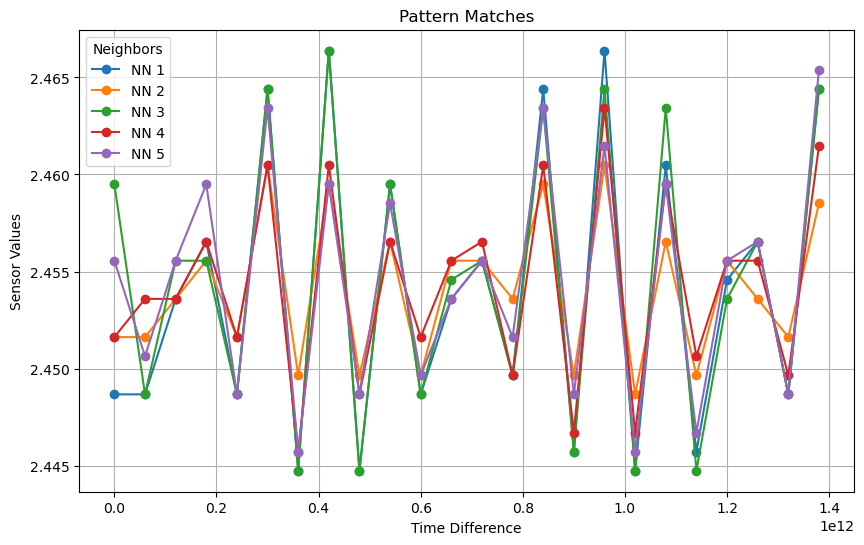

In [48]:
# Group by neighbour and plot each group separately with a legend
nn1_groups = full_nn1_df.groupby("pattern")
fig, ax    = plt.subplots(figsize=(10, 6))

for name, group in nn1_groups:
    ax.plot(group["time_difference"], group["sensor_00"], marker="o", label=f"NN {name}" )

ax.set_xlabel("Time Difference")
ax.set_ylabel("Sensor Values")
ax.legend(title="Neighbors")
plt.title("Pattern Matches")
plt.grid(True)
plt.show()

Remember the blue line `NN 1` is our query vector, we can see the overall pattern matches closely with the other matches found. 

Let's try another input query and see what result we get.

### Automate This Pattern Matching Process

In [44]:
def visualize_neighbors( table, df: pd.DataFrame, embedding_df: pd.DataFrame, pattern_time, n_neighbors: int) -> None:
    # Select historical pattern
    example_window1 = embedding_df[embedding_df["start_time"] == pattern_time]

    # Extract the sensor values in this window
    query_vector1 = example_window1["vectors"].values.tolist()

    # search the KDB.AI table
    nn_result = table.search(query_vector1, n=5)

    # Iterate through the rows of df1 to filter df and calculate time differences
    full_nn_df = pd.DataFrame()
    for i, row in nn_result[0].iterrows():
        filtered_df = sensors_df[ (sensors_df["timestamp"] >= row["start_time"]) & (sensors_df["timestamp"] <= row["end_time"])].copy()
        filtered_df["time_difference"] = filtered_df["timestamp"] - row["start_time"]
        filtered_df["pattern"]         = i + 1
        full_nn_df                     = pd.concat([full_nn_df, filtered_df])

    # Group by neighbour and plot each group separately with a legend
    nn1_groups = full_nn1_df.groupby("pattern")
    fig, ax    = plt.subplots(figsize=(10, 6))

    for name, group in nn1_groups:
        ax.plot( group["time_difference"], group["sensor_00"], marker="o", label=f"NN {name}")

    ax.set_xlabel("Time Difference")
    ax.set_ylabel("Sensor Values")
    ax.legend(title="Neighbors")
    plt.title("Pattern Matches")
    plt.grid(True)
    plt.show()

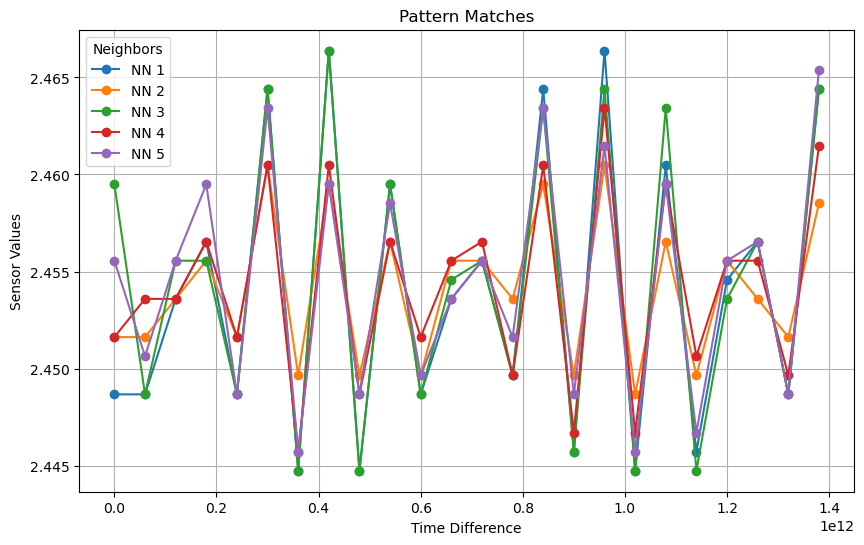

In [46]:
visualize_neighbors(table, sensors_df, embedding_df, pd.to_datetime("2018-04-12 21:10:00"), 5)

This is also a pretty close match! 

We can see even with a simplistic method for embedding our time series data we can yield satisfactory results.

## 5. Delete the KDB.AI Table

Once finished with the table, it is best practice to drop it.

In [44]:
table.drop()

True

## Take Our Survey

We hope you found this sample helpful! Your feedback is important to us, and we would appreciate it if you could take a moment to fill out our brief survey. Your input helps us improve our content.

[**Take the Survey**](https://delighted.com/t/go0ElNsJ)